In [40]:
import time
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import wavfile
import IPython.display as ipd
from scipy import fftpack

#### Load the data

In [41]:

# Load the data
rate, samples, = wavfile.read("tada.wav")

#### Set Phsyics Sound Parameters

In [42]:
# Sound parameters and calculations
speed_of_sound = 34300 #cm/s
ear_distance = 16 #cm
max_delay = int(1.4 * rate * ear_distance / speed_of_sound)

#### Generate Sample Distortions and set distortion parameters

In [43]:
# Distort parameters
volume = .5
noise_level = 2
delay = -10
sample_select = 20000

def distort(samples, volume, noise_level, delay, sample_select = 20000):
    """Distorts the given samples by adding noise, changing the volume, and delaying the samples"""
    # Prepare our dirty data
    np.random.seed(int(100000000 * time.time()) % 717327221)
    samples = samples[:-sample_select].copy()
    avg_magnitude = np.mean(abs(samples))
    noise = np.random.uniform(-1, 1, len(samples))
    epsilon = noise_level * avg_magnitude * noise
    new_samples = (samples + epsilon) * volume

    # add delay
    if delay < 0:
        new_samples = new_samples[:delay]
        samples = samples[-delay:]
    elif delay != 0:
        new_samples = new_samples[delay:]
        samples = samples[:-delay]

    return samples, new_samples


def plot_sounds(sound1, sound2, size = False):
    """Plots two sounds on top of each other"""
    plt.figure(figsize=(10, 8))
    if size == False:
        plt.subplot(2,1,1)
        plt.title("Original")
        plt.plot(sound1)
        plt.subplot(2,1,2)
        plt.title("Noisy")
        plt.plot(sound2)
    else:
        plt.subplot(2,1,1)
        plt.title("Original")
        plt.plot(sound1[-size:])
        plt.subplot(2,1,2)
        plt.title("Noisy")
        plt.plot(sound2[-size:])
    plt.show()

#### Set optimization functions and optimiztion parameters

In [44]:
# Optimization parameter
window_size = 1000

def sliding_optimize(sound1, sound2, window_size=5000):
    """Finds the delay between two sounds using a sliding optimization method"""
    # Get the last window_size samples
    sound1 = sound1[-window_size:]
    sound2 = sound2[-window_size:]
    
    # Initialize the scores and delay values arrays and get the length of the sounds
    delay_vals = np.arange(-max_delay+1, max_delay)
    scores = np.empty(delay_vals.shape)
    scale = np.sqrt(len(sound1))

    # Loop through the possible delay values and trim the sounds accordingly
    for i, delay in enumerate(delay_vals):
        if delay > 0:
            test1 = sound1[delay:]
            test2 = sound2[:-delay]

        # If the delay is negative, account for python's negative indexing
        elif delay < 0:
            test1 = sound1[:delay]
            test2 = sound2[-delay:]

        # If the delay is 0, just use the sounds as is
        else:
            test1 = sound1
            test2 = sound2
        
        # Calculate the difference between the two sounds and normalize it
        scores[i] = np.linalg.norm(test1 - test2, 2) / scale

    # Find the argmin of the scores to see which delay is most alligned, and return the delay value
    min_index = np.argmin(scores)
    return delay_vals[min_index]


def sliding_list(sound1, sound2, window_size=5000):
    """Finds the delay between two sounds using a sliding optimization method"""
    # Get the last window_size samples
    sound1 = sound1[-window_size:]
    sound2 = sound2[-window_size:]
    
    # Initialize the scores and delay values arrays and get the length of the sounds
    delay_vals = np.arange(-max_delay+1, max_delay)
    scores = np.empty(delay_vals.shape)
    scale = np.sqrt(len(sound1))

    # Loop through the possible delay values and trim the sounds accordingly
    for i, delay in enumerate(delay_vals):
        if delay > 0:
            test1 = sound1[delay:]
            test2 = sound2[:-delay]

        # If the delay is negative, account for python's negative indexing
        elif delay < 0:
            test1 = sound1[:delay]
            test2 = sound2[-delay:]

        # If the delay is 0, just use the sounds as is
        else:
            test1 = sound1
            test2 = sound2
        
        # Calculate the difference between the two sounds and normalize it
        scores[i] = np.linalg.norm(test1 - test2, 2) / scale
    return scores


def triangulate(sound1, sound2, sound3, window_size = 5000):
    """Finds the delay between three sounds using a sliding optimization method"""
    delay_2 = sliding_optimize(sound1, sound2, window_size)
    delay_3 = sliding_optimize(sound1, sound3, window_size)
    return delay_2, delay_3


#### Run Simulations

Actual delay:  -10
Found delay:  -10
Time:  0.0004706382751464844


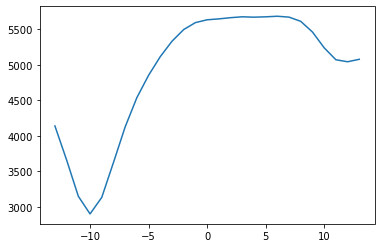

In [45]:
sample1, sample2 = distort(samples, volume, noise_level, delay, sample_select)
nothing, sample3 = distort(samples, .7, 2, -1, sample_select)


start = time.time()
found_delay = sliding_optimize(sample1, sample2, window_size)
end = time.time()

# plot the optimization graph and use the x 
plt.plot(np.arange(-max_delay+1, max_delay), sliding_list(sample1, sample2, window_size))

# Print the delay and time it took
print("Actual delay: ", delay)
print("Found delay: ", found_delay)
print("Time: ", end - start)

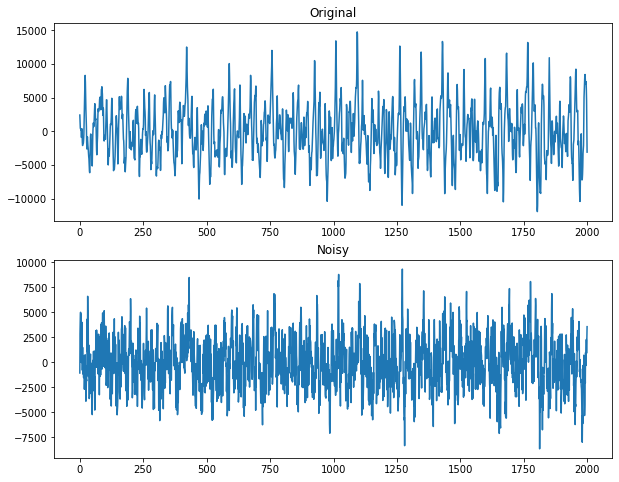

In [46]:
# Plot the sounds
plot_sounds(sample1, sample2, size = 2000)

In [47]:
# Get the triangulated delay for the three sounds
delay_2, delay_3 = triangulate(sample1, sample2, sample3, window_size)
print("Delay 2: ", delay_2)
print("Delay 3: ", delay_3)

Delay 2:  -10
Delay 3:  -1
